In [1]:
# import basic modules
import pandas as pd
import numpy as np
import urllib
import warnings
warnings.filterwarnings("ignore")

# import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
plt.style.use('ggplot')

# import statistic modules
from scipy import stats
from scipy.stats import chi2_contingency

# import relevant sklean modules
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, mean_squared_error,classification_report
from sklearn.metrics import make_scorer, confusion_matrix

In [2]:
# read in kyc data
file_path = 'UofT_nodes.csv'
df = pd.read_csv(file_path,  dtype=str)

In [3]:
# Preprocess string variables into numerical variables
df['COUNTRY_RISK_INCOME'] = df['COUNTRY_RISK_INCOME'].astype('category').cat.codes
df['COUNTRY_RISK_RESIDENCY'] = df['COUNTRY_RISK_RESIDENCY'].astype('category').cat.codes
df['RISK'] = df['RISK'].replace(['low'], 0)
df['RISK'] = df['RISK'].replace(['medium'], 1)
df['RISK'] = df['RISK'].replace(['high'], 2)
df['GENDER'] = df['GENDER'].astype('category').cat.codes
df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype(float)

# Set numeric variables as float data type
for i in range(2, 13):
  df.iloc[:, i] = df.iloc[:, i].astype(float)

In [4]:
# Retain relevant columns
feature = ['CUSTOMER_ID','PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN',
           'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
           'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'RISK']
df_new = df[feature]

# Graph Data
New Features:
- EMT_SUM_OUT: Total Amount in EMTs Sent
- EMT_SUM_IN: Total Amount in EMTs Received
- OUTGOING_BA: Number of Transactions Sent to Bad Actors
- INCOMING_BA: Number of Transactions Received from Bad Actors

In [5]:
# read in graph and bad actor datasets
df_edges = pd.read_csv('UofT_edges.csv')
df_ba = pd.read_csv('badactor_foundin_kyc_bt_match.csv', index_col=0)

In [6]:
# identify bad actors in the processed kyc data
bad_actors = df_ba['CUSTOMER_ID'].tolist()
df_new['BAD_ACTOR'] = df_new['CUSTOMER_ID'].isin(bad_actors).astype(int)

In [7]:
# identify num of OUTGOING payments users have with bad actors
df_new_v1 = df_new.merge(df_edges, left_on="CUSTOMER_ID", right_on="source", how="left")\
                   .drop("source",axis=1)\
                   .rename(columns={'emt':'EMT_SUM_OUT'}) # join kyc and graph data

df_new_v1['OUTGOING_BA'] = df_new_v1['target'].isin(bad_actors).astype(int)
df_new_v1 = df_new_v1.drop("target", axis=1).fillna(0)

# take a sum of the outgoing emt amount per user
df_new_v1 = df_new_v1.groupby(df_new.columns.tolist()).sum().reset_index()

In [8]:
# identify num of INCOMING payments users have with bad actors
df_new_v2 = df_new_v1.merge(df_edges, left_on="CUSTOMER_ID", right_on="target", how="left")\
                   .drop("target",axis=1)\
                   .rename(columns={'emt':'EMT_SUM_IN'})

df_new_v2['INCOMING_BA'] = df_new_v2['source'].isin(bad_actors).astype(int)
df_new_v2 = df_new_v2.drop("source", axis=1).fillna(0)

# take a sum of the incoming emt amount per user
df_graph = df_new_v2.groupby(df_new_v1.columns.tolist()).sum().reset_index()

# remove customer id from final datasets
df_graph.drop('CUSTOMER_ID', axis=1, inplace=True)
df_new.drop('CUSTOMER_ID', axis=1, inplace=True)

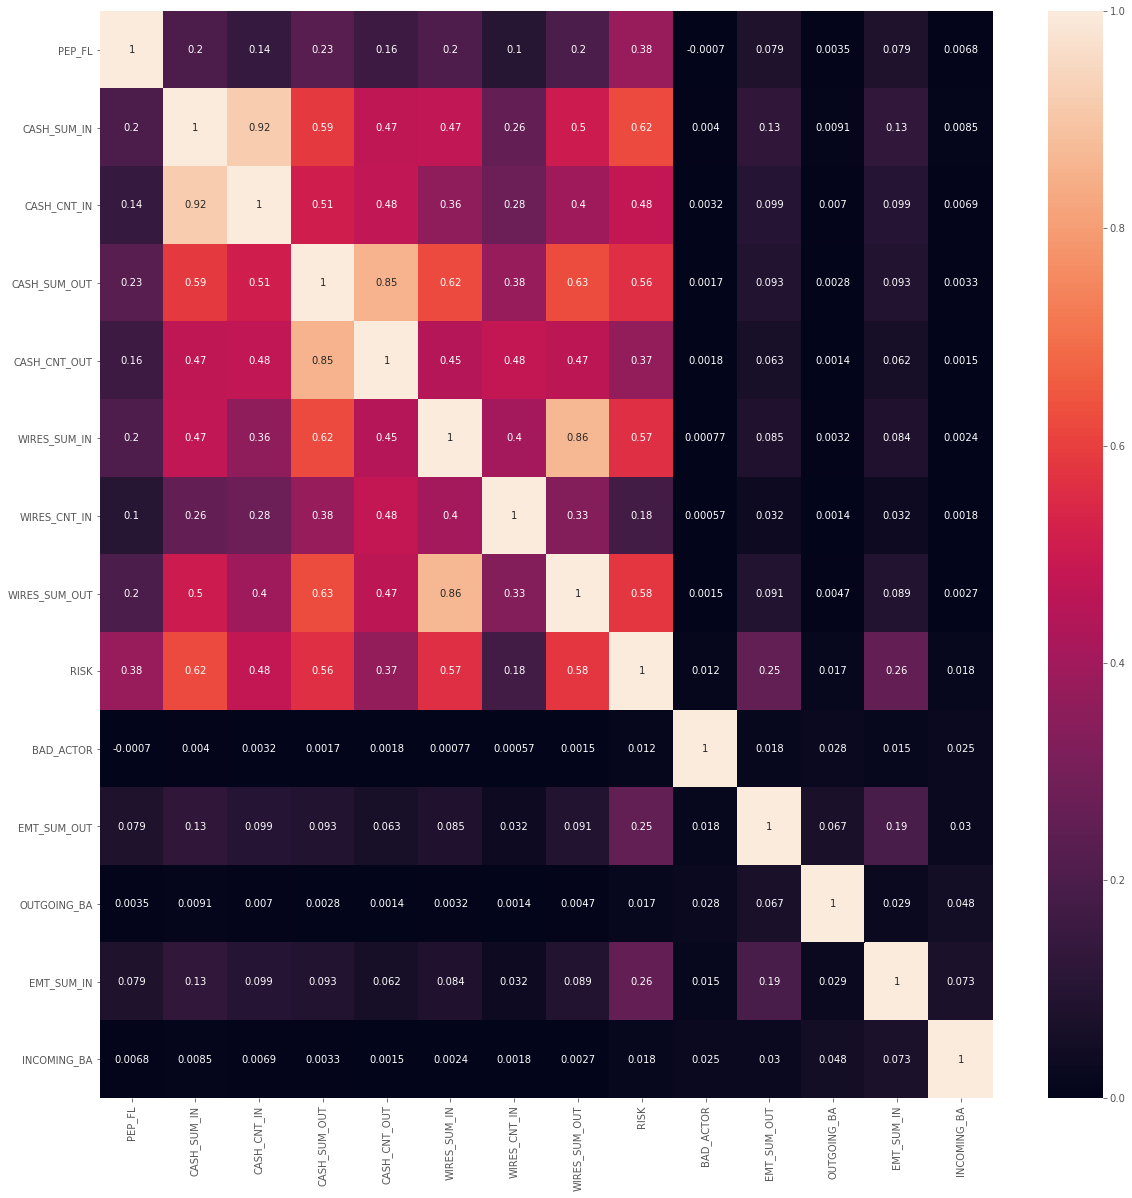

In [9]:
plt.figure(figsize=(20,20))
sns.heatmap(df_graph.corr(), annot=True)
plt.show()

# Logistic

In [12]:
from sklearn.linear_model import LogisticRegression

def logistic_model(dataset):    
    X = dataset.drop('RISK',axis=1)
    y = dataset['RISK']
    scaler = StandardScaler()

    kf = StratifiedKFold(n_splits=10)
    results = []

    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)    

        model = LogisticRegression(multi_class='auto', solver='lbfgs')
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        results.append(accuracy)

    avg_accuracy = np.mean(results)
    print('Average accuracy:', avg_accuracy)

In [13]:
# Logistic classifier with baseline dataset
logistic_model(df_new)

Average accuracy: 0.950645


In [14]:
# Logistic classifier with datasets with graph-related features
logistic_model(df_graph)

Average accuracy: 0.958137


# RF

In [15]:
from sklearn.ensemble import RandomForestClassifier

def randomforest_model(dataset):    
    X = dataset.drop('RISK',axis=1)
    y = dataset['RISK']
    scaler = StandardScaler()

    kf = StratifiedKFold(n_splits=5)
    results = []

    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)    

        model = RandomForestClassifier(n_estimators=100, random_state=0)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        results.append(accuracy)

    avg_accuracy = np.mean(results)
    print('Average accuracy:', avg_accuracy)

In [16]:
# Random forest classifier with baseline dataset
randomforest_model(df_new)

Average accuracy: 0.9534879999999999


In [17]:
# Random forest classifier with datasets with graph-related features
randomforest_model(df_graph)

Average accuracy: 0.963195
